3 states have been removed from the model
2 states have been removed from the model
0 states have been removed from the model
1 states have been removed from the model
6 states have been removed from the model


c:\Users\afons\miniconda3\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(
c:\Users\afons\miniconda3\Lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


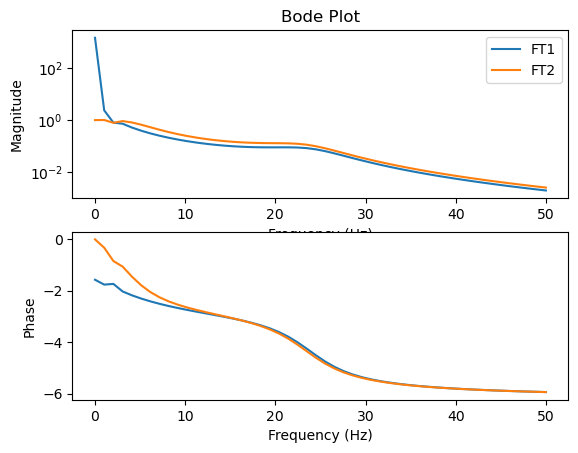

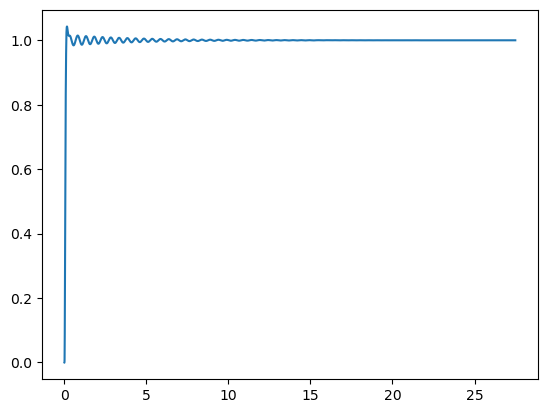

RiseTime: 0.06598227566581952
SettlingTime: 2.336872263164441
SettlingMin: 0.9070679919088219
SettlingMax: 1.0428920117847043
Overshoot: 4.289201139269969
Undershoot: 0
Peak: 1.0428920117847043
PeakTime: 0.15945716619239717
SteadyStateValue: 1.0000000003758822


In [31]:
#Mesa Sismica ST1D
#modelo com sistema 1DOF acoplado

import os
import numpy as np
import matplotlib.pyplot as plt   # MATLAB plotting functions
import control as ct
from control.matlab import *  # MATLAB-like functions
import math


#Servo-valve parameters
tsv=0.0246      #Valve time constant (tsv=0.0246 s)
ksvkq=1934.5    #Valve flow gain (ksvkq=1934.5 cm3/s/V)
kpl=1.67401e-7  #Valve pressure gain & leakadge factor (kpl=1.67401e-7 m3/s/kPa)
Be=193716.28    #Oil Bulk modulus (Be=193716.28 kPa)
Vt=0.002659     #Oil Volume on actuator chamber (Vt=0.002659 m3)
A=0.012456      #Piston area (A=0.012456 m2)
mp=1.9751       #Platen mass (mp=1.9751 t)
ctm=5.78        #Total damping, actuator + platen (ct=5.78 kN s/m)
kh=4*Be*A**2/Vt #(kPa m)

#Additional 1DOF model
msp=2                             #Rigid mass (t)
fn1dof=2                          #Natural frequency (Hz)
zeta1dof=0.02                     #damping ratio (2%)
wn1dof=2*math.pi*fn1dof           #Natural frequency (rad/s)
cct=2*msp*wn1dof                  #critical damping (t/s)
csp=zeta1dof*cct                  #damping (t/s)
ksp=wn1dof**2*msp                 #stiffness (t/s^2)


#Controller
kp=1.2993       #Pgain (kp=1.2993 V/cm)
#kp=3
#kp=0.707

s=tf('s')

#1DOF model
Hsp=-msp*s*s/(msp*s*s+csp*s+ksp)
mt=mp+msp*(1+Hsp)
#mt=mp+msp      #massa rigida

#-----------------1DOFmodel -> SS model variaveis z={xsp,xp,dot_xsp,dot_xp}---------------------------
#Sistema SS: dz/dt=A*z+B*f; y=Ci*z+D*f
#M,C,K, com variáveis {Xsp=xs-xp; Xp}, entrada força atuador - fp
Mmsp=[[msp, msp], [msp, msp+mp]]
Cmsp=[[csp, 0], [0, ctm]]
Kmsp=[[ksp, 0], [0, 0]]
Gmsp=[[0],[1]]
n=np.size(Kmsp,1)
#As=[zeros(n),eye(n);-M^-1*K,M^-1*C]
As=np.zeros([2*n,2*n])
As[0:n,n:2*n+1]=np.eye(n)
As[n:2*n+1,0:n]=np.dot(-np.linalg.inv(Mmsp),Kmsp)
As[n:2*n+1,n:2*n+1]=np.dot(-np.linalg.inv(Mmsp),Cmsp)
#Bs
Bs=np.zeros([2*n,1]); Bs[n:2*n+1]=np.dot(np.linalg.inv(Mmsp),Gmsp)
#Cs= todos os estados (desl. e velocidade)
Cs=np.eye(2*n); Ds=np.zeros([2*n,1])
#Cs=np.zeros([n,2*n]);Cs[0:n,0:n]=np.eye(n); Ds=np.zeros([n,1])
#sistema
Hspss=ct.matlab.ss(As,Bs,Cs,Ds,inputs=['fp'], outputs=['xsp','xp','d/dt_xsp','d/dt_xp'], states=['xsp','xp','d/dt_xsp','d/dt_xp'])

#xsp/xp
#Xsp/f
Hspss_1=ct.ss(As,Bs,Cs[0,0:2*n],Ds[0,0])
Hspss_1tf=ct.ss2tf(Hspss_1)
#Xp/f
Hspss_2=ct.ss(As,Bs,Cs[1,0:2*n],Ds[1,0])
Hspss_2tf=ct.ss2tf(Hspss_2)
#xsp/xp
Hspss_tf=minreal(Hspss_1tf/Hspss_2tf)

#ct.damp(Hspss_tf)

#------------------------------------------------------------------

#FT do anel aberto Gaa=xp/isv
Gaa=10**-4*A*kh*ksvkq/(s*(s*tsv + 1)*(A**2*ctm*s + A**2*kh + A**2*mt*s**2 + kpl*ctm*kh + kpl*kh*mt*s))
Gaa2=minreal(Gaa)     #reducao do modelo

#FT do anel aberto Gaa=xp/isv com MASSA RIGIDA
Gaa_r=10**-4*A*kh*ksvkq/(s*(s*tsv + 1)*(A**2*ctm*s + A**2*kh + A**2*(mp+msp)*s**2 + kpl*ctm*kh + kpl*kh*mt*s))
Gaa_r2=minreal(Gaa_r)     #reducao do modelo

#FT do anel aberto com saída em aceleração: Gaa=ap/isv
Gaa_a=Gaa2*s*s;
Gaa_a2=minreal(Gaa_a)

#Modelo com parametros aproximados para Labview
#Gaa=ct.tf([1.44520985e+07, 7.26441171e+06, 2.28218391e+09], [1.00000000e+00, 9.33711859e+01, 2.55461065e+04, 9.78885347e+05, 4.75713218e+06, 1.47863335e+08, 0.00000000e+00])


Gxr=10**-4*A*kh*kp*ksvkq/(10**-4*A*kh*kp*ksvkq + s*(s*tsv + 1)*(A**2*ctm*s + A**2*kh + A**2*mt*s**2 + kpl*ctm*kh + kpl*kh*mt*s))

#FT do anel fechado
Gxraf=Gaa*kp/(1+Gaa*kp)
Gxraf2=minreal(Gxraf)     #reducao do modelo


#Visualização
FT1=Gaa

FT2=Gxraf2

# Bode plot for the system
plt.figure(1)
plt.subplot(2, 1, 1)
mag, phase, om = bode(FT1, linspace(0.01, 50*6.28), dB=False, plot=False)
mag2, phase2, om2 = bode(FT2, linspace(0.01, 50*6.28), dB=False, plot=False)
#mag, phase, om = bode(Gxr, logspace(-2, 2), plot=True)
#mag, phase, om = bode(Gxr, Hz=True, dB=False, plot=True)
plt.semilogy(om/6.28, mag, om2/6.28, mag2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude") 
plt.title("Bode Plot")
plt.gca().legend(('FT1','FT2'))
plt.subplot(2, 1, 2)
plt.plot(om/6.28, phase,om2/6.28, phase2)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Phase")

# Step response for the system
plt.figure(2)
yout, T = step(FT1)
yout2, T2 = step(FT2)
#plt.plot(T.T, yout.T,T2.T, yout2.T)
#plt.gca().legend(('FT1','FT2'))
plt.plot(T2.T, yout2.T)
plt.show(block=False)


S_FT2 = ct.step_info(FT2, SettlingTimeThreshold=0.01)
for k in S_FT2:
    print(f"{k}: {S_FT2[k]}")


#import numpy as np
#Gxr2.den/Gxr2.den[0][0][4]
#Gxr.den/Gxr.den[0][0][4]

In [32]:
ct.damp(Hsp)

    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


(array([12.56637061, 12.56637061]),
 array([0.02, 0.02]),
 array([-0.25132741+12.56385709j, -0.25132741-12.56385709j]))

In [33]:
mt

TransferFunction(array([   3.9502    ,    3.99620639, 1255.44526255]), array([  2.        ,   1.00530965, 315.82734083]))

In [34]:
#modelo SS Hsp
minreal(Hspss_tf)

0 states have been removed from the model


TransferFunction(array([-1.00000000e+00,  4.36621597e-14, -3.72885819e-28]), array([  1.        ,   0.50265482, 157.91367042]))

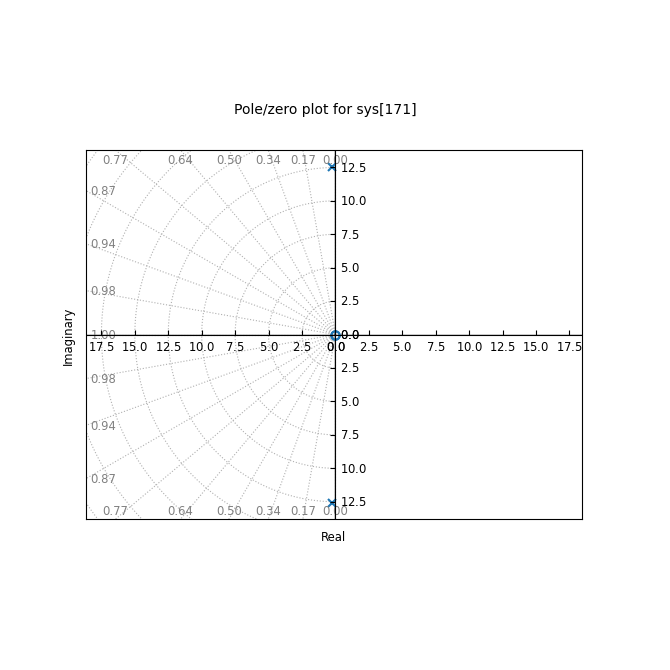

In [35]:
#Sistema Controlado Hsp=xsp/xp
ct.pzmap(Hsp, grid='true')

In [36]:
[wnHsp,zetaHsp,poleHsp]=ct.damp(Hsp)

    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


In [37]:
Gaa_r2

TransferFunction(array([7.18078531e+06, 3.60945638e+06, 1.13394417e+09]), array([1.00000000e+00, 6.68456749e+01, 1.26930430e+04, 4.86376808e+05,
       2.36366677e+06, 7.34685599e+07, 0.00000000e+00]))

In [38]:
ct.damp(Gaa_r2)

    Eigenvalue (pole)       Damping     Frequency
    -12.67    +106.2j        0.1185           107
    -12.67    -106.2j        0.1185           107
               -40.65             1         40.65
   -0.4229    +12.56j       0.03366         12.56
   -0.4229    -12.56j       0.03366         12.56
                    0             1             0


c:\Users\afons\miniconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


(array([106.99949482, 106.99949482,  40.6504065 ,  12.56425059,
         12.56425059,   0.        ]),
 array([0.11845568, 0.11845568, 1.        , 0.03366188, 0.03366188,
               nan]),
 array([-12.67469794+106.24614781j, -12.67469794-106.24614781j,
        -40.6504065   +0.j        ,  -0.42293627 +12.55713016j,
         -0.42293627 -12.55713016j,   0.          +0.j        ]))

In [39]:
Gaa2

TransferFunction(array([1.44520985e+07, 7.26441257e+06, 2.28218392e+09]), array([1.00000000e+00, 9.33711859e+01, 2.55461065e+04, 9.78885347e+05,
       4.75713218e+06, 1.47863335e+08, 0.00000000e+00]))

In [40]:
ct.damp(Gaa2)

    Eigenvalue (pole)       Damping     Frequency
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
               -40.65             1         40.65
   -0.4183    +12.51j       0.03341         12.52
   -0.4183    -12.51j       0.03341         12.52
                    0             1             0


(array([152.32469805, 152.32469805,  40.6504065 ,  12.52066731,
         12.52066731,   0.        ]),
 array([0.17030794, 0.17030794, 1.        , 0.0334075 , 0.0334075 ,
               nan]),
 array([-25.94210558+150.09936973j, -25.94210558-150.09936973j,
        -40.6504065   +0.j        ,  -0.41828415 +12.51367845j,
         -0.41828415 -12.51367845j,   0.          +0.j        ]))

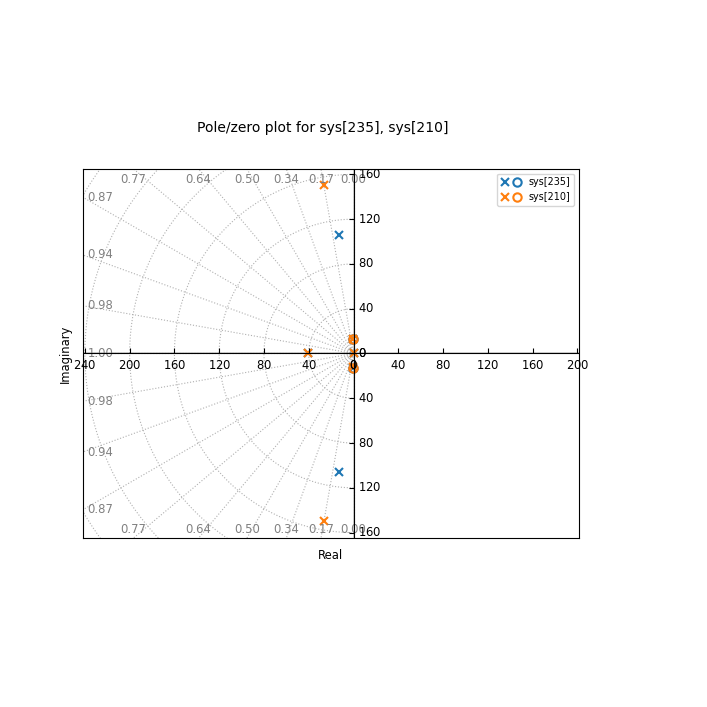

In [41]:
#ct.pzmap(Gaa_r2, grid='true')   #Sistema com massa rigida
#ct.pzmap(Gaa2, grid='true')     #Sistema com 1DOF
ct.pzmap([Gaa_r2,Gaa2], grid='true') #Comparação sistema com massa rigida vs. 1DOF

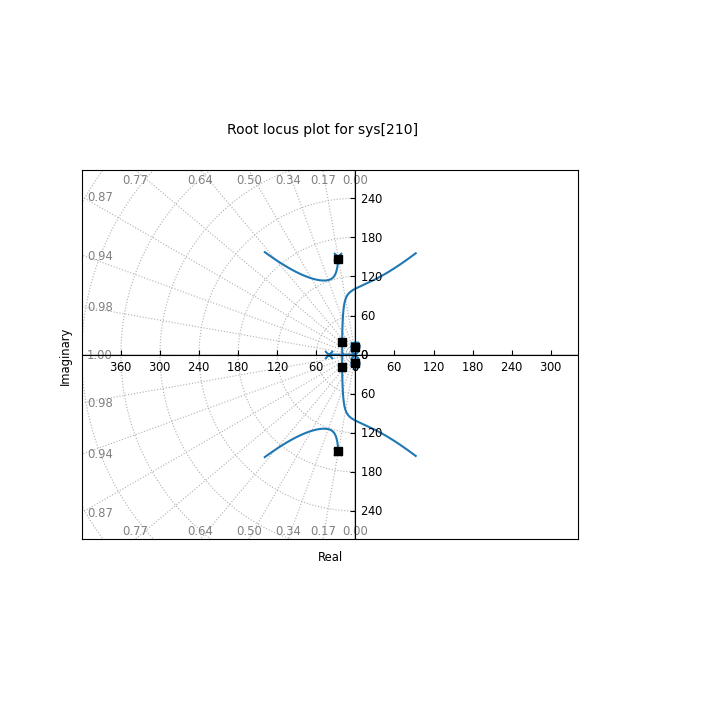

In [42]:
#Controlador Proporcional
#P:  C_f = kc
#ct.root_locus(Gaa_r2,np.linspace(0, 100, num=5000),grid='true', initial_gain=1.2) #massa rigida
ct.root_locus(Gaa2,np.linspace(0, 100, num=5000),grid='true', initial_gain=1.2) #massa rigida
#ct.root_locus([Gaa_r2,Gaa2],np.linspace(0, 100, num=5000),grid='true', initial_gain=0.5)


In [43]:
[wnGaa2,zetaGaa2,poleGaa2]=ct.damp(Gaa2)

    Eigenvalue (pole)       Damping     Frequency
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
               -40.65             1         40.65
   -0.4183    +12.51j       0.03341         12.52
   -0.4183    -12.51j       0.03341         12.52
                    0             1             0


c:\Users\afons\miniconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


In [44]:
Gaa2z=zeros(Gaa2)
Gaa2z[0]

(-0.25132725825741087+12.563857107630055j)

In [45]:
#z1=-1+0.5j
z1=poleGaa2[3]

z2=np.conj(z1)

Comp_Gaa2=((s-z1)*(s-z2))/((s-Gaa2z[0])*(s-Gaa2z[1]))
ct.damp(minreal(Comp_Gaa2))

0 states have been removed from the model
    Eigenvalue (pole)       Damping     Frequency
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57


c:\Users\afons\miniconda3\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\afons\miniconda3\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


(array([12.56637063, 12.56637063]),
 array([0.01999999, 0.01999999]),
 array([-0.25132726+12.56385711j, -0.25132726-12.56385711j]))

In [46]:
#Sistema Compensado
Gaa2comp=minreal(Gaa2*Comp_Gaa2)

4 states have been removed from the model


In [47]:
Gaa2comp

TransferFunction(array([14452098.47230348+0.j]), array([1.00000000e+00, 9.25346177e+01, 2.53119279e+04, 9.43203806e+05,
       0.00000000e+00]))

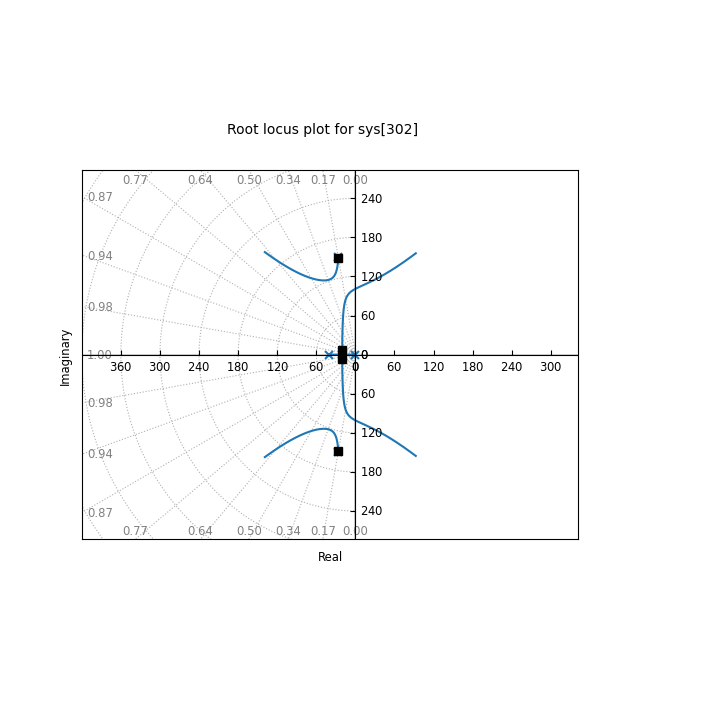

In [48]:
#Sistema compensado com Controlador Proporcional
#P:  C_f = kc
ct.root_locus(Gaa2comp,np.linspace(0, 100, num=5000),grid='true',initial_gain=0.707) #1DOF

c:\Users\afons\miniconda3\Lib\site-packages\control\xferfcn.py:1087: ComplexWarning: Casting complex values to real discards the imaginary part
  den[j, :maxindex+1] = poly(poles[j])
c:\Users\afons\miniconda3\Lib\site-packages\control\xferfcn.py:1117: ComplexWarning: Casting complex values to real discards the imaginary part
  num[i, j, maxindex+1-len(numpoly):maxindex+1] = numpoly


4 states have been removed from the model


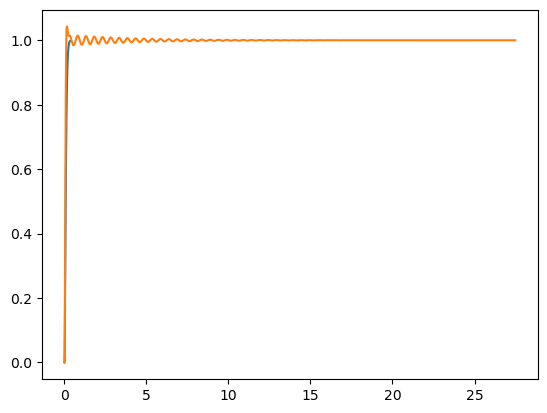

RiseTime: 0.14435384341658916
SettlingTime: 0.28207072851517423
SettlingMin: 0.9000401312841355
SettlingMax: 0.9999999999999813
Overshoot: 0
Undershoot: 0
Peak: 0.9978923247094723
PeakTime: 0.3418033533772111
SteadyStateValue: 0.9999999999999813


In [49]:
# Step response for the system
kp3=0.707
FT3=minreal(Gaa2comp*kp3/(1+Gaa2comp*kp3))

plt.figure(3)
yout3, T3 = step(FT3)

plt.plot(T3.T, yout3.T,T2.T, yout2.T)
#plt.plot(T3.T, yout3.T)
plt.show(block=False)


S_FT3 = ct.step_info(FT3, SettlingTimeThreshold=0.01)
for k in S_FT3:
    print(f"{k}: {S_FT3[k]}")

In [50]:
minreal(FT3)

0 states have been removed from the model


TransferFunction(array([10217633.61991856+0.j]), array([1.00000000e+00, 9.25346177e+01, 2.53119279e+04, 9.43203806e+05,
       1.02176336e+07]))

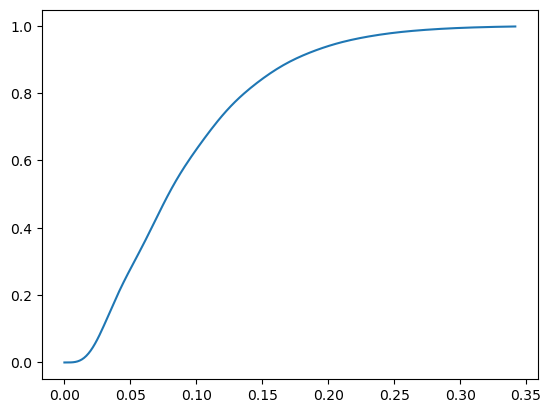

In [51]:
plt.plot(T3.T, yout3.T)

In [52]:
damp(Gaa2comp)

    Eigenvalue (pole)       Damping     Frequency
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
               -40.65             1         40.65
                    0             1             0


c:\Users\afons\miniconda3\Lib\site-packages\control\lti.py:57: RuntimeWarning: invalid value encountered in divide
  zeta = -real(splane_poles)/wn


(array([152.32469805, 152.32469805,  40.6504065 ,   0.        ]),
 array([0.17030794, 0.17030794, 1.        ,        nan]),
 array([-25.94210558+150.09936973j, -25.94210558-150.09936973j,
        -40.6504065   +0.j        ,   0.          +0.j        ]))

In [53]:
zeros(Gaa2comp)

array([], dtype=complex128)

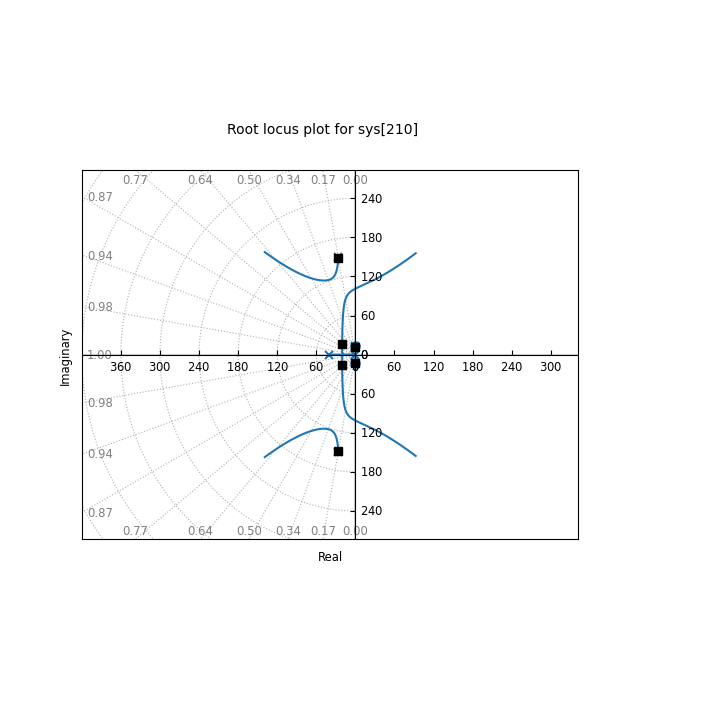

In [54]:
#Sistema não compensado com Controlador Proporcional
#P:  C_f = kc
ct.root_locus(Gaa2,np.linspace(0, 100, num=5000),grid='true',initial_gain=1) #1DOF



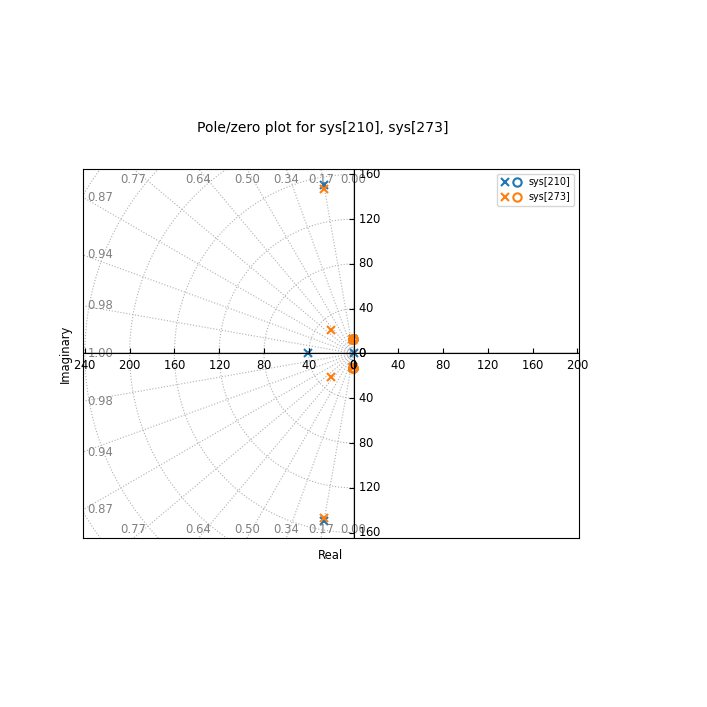

In [55]:
ct.pzmap([Gaa2, Gxraf2],grid='true')

In [56]:
Gxraf2

TransferFunction(array([1.87776115e+07, 2.83159711e+07, 8.90995784e+09, 8.94534263e+09,
       1.40700415e+12, 7.06107649e+11, 7.39434202e+13]), array([1.00000000e+00, 9.43764956e+01, 2.59560535e+04, 1.03423861e+06,
       3.26331996e+07, 4.96751650e+08, 1.13546771e+10, 8.08473877e+10,
       1.54910507e+12, 4.39333530e+12, 7.39434202e+13]))

In [57]:
ct.damp(Gxraf2)

    Eigenvalue (pole)       Damping     Frequency
    -26.16    +147.3j        0.1749         149.6
    -26.16    -147.3j        0.1749         149.6
    -20.27    +21.07j        0.6934         29.24
    -20.27    -21.07j        0.6934         29.24
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57
   -0.2513    +12.56j          0.02         12.57
   -0.2513    -12.56j          0.02         12.57
   -0.2543    +12.45j       0.02042         12.45
   -0.2543    -12.45j       0.02042         12.45


(array([149.5586026 , 149.5586026 ,  29.2372138 ,  29.2372138 ,
         12.56640686,  12.56640686,  12.56633437,  12.56633437,
         12.45324858,  12.45324858]),
 array([0.17491122, 0.17491122, 0.69335554, 0.69335554, 0.02000157,
        0.02000157, 0.01999843, 0.01999843, 0.02042292, 0.02042292]),
 array([-26.15947697+147.25303859j, -26.15947697-147.25303859j,
        -20.27178429 +21.06820904j, -20.27178429 -21.06820904j,
         -0.25134781 +12.56389294j,  -0.25134781 -12.56389294j,
         -0.25130699 +12.56382124j,  -0.25130699 -12.56382124j,
         -0.25433172 +12.45065121j,  -0.25433172 -12.45065121j]))

In [58]:
zeros(Gxraf2)

array([-0.25151756+12.56415268j, -0.25151756-12.56415268j,
       -0.25097667+12.56387423j, -0.25097667-12.56387423j,
       -0.25148801+12.56354436j, -0.25148801-12.56354436j])

In [59]:
# pip install -q ipywidgets

In [ ]:
import ipywidgets as wg
from ipywidgets import interactive, fixed
#PID: C_f = Kp + Ki/s + Kd*s/(tau*s + 1).
#PID: C_f=Kc(1+1/Ti/s+Td*s); kp=kc; ki=kc/Ti; kd=kc*Td;

#Ti=0.01
#Td=0
#
##def RLplot(tauI,tauD):
#    
#interactive(ct.root_locus(Gaa2*(1+1/(s*Ti)+Td*s)),Ti=(0.01,1000),Td=(0.0,50.0))
#tauI_slide = wg.FloatSlider(value=4.0,min=0.01,max=5.0,step=0.1)
#wg.interact(ct.root_locus(Gaa2*(1+1/(s*Ti)+Td*s)), Ti=tauI_slide)

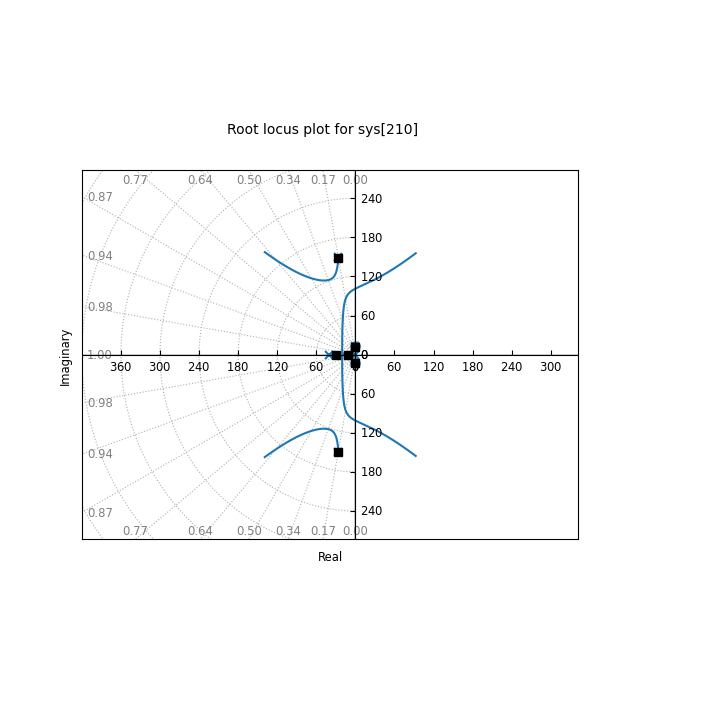

In [62]:
#Controlador Proporcional
#P:  C_f = kc
ct.root_locus(Gaa2,np.linspace(0, 100, num=5000),grid='true', initial_gain=0.5)

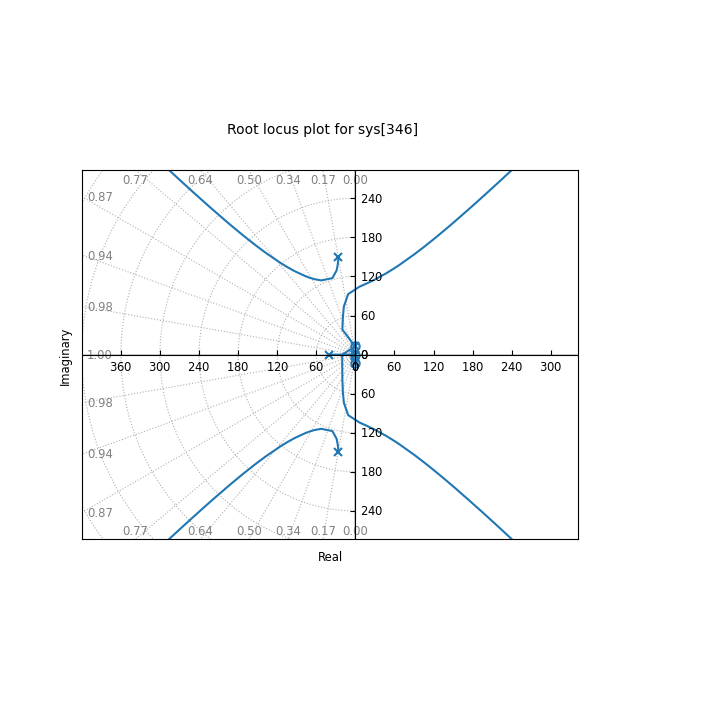

In [63]:
#PID: C_f = Kp + Ki/s + Kd*s/(tau*s + 1).
#PID: C_f=Kc(1+1/Ti/s+Td*s); kp=kc; ki=kc/Ti; kd=kc*Td;
#PI: C_f = kc(1+1/Ti/s)

Ti=10**10
ct.root_locus(Gaa2*(1+1/(s*Ti)))

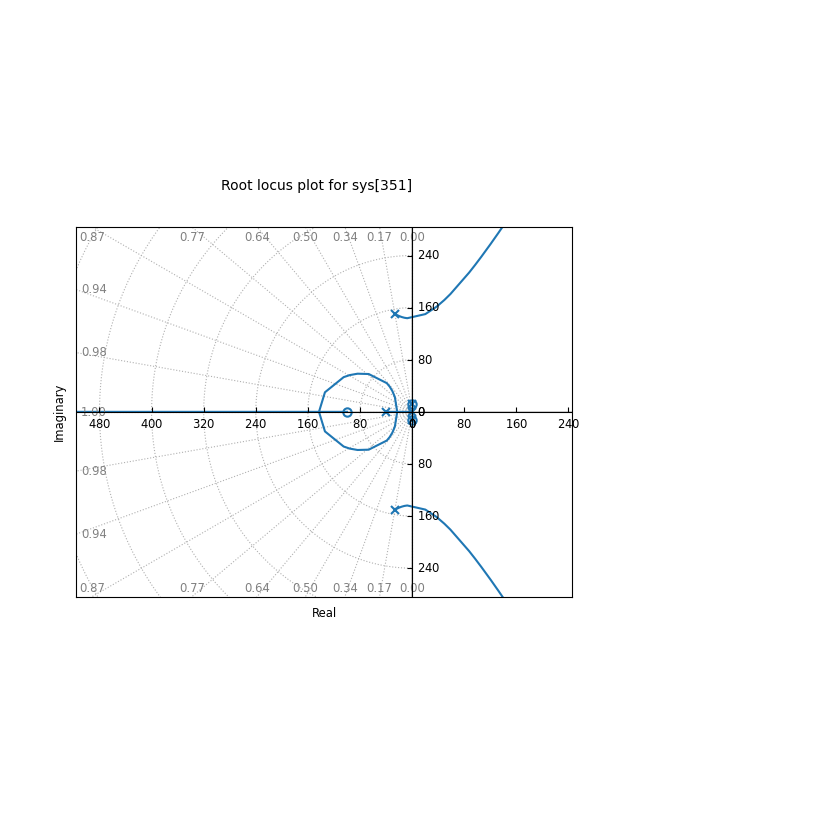

In [64]:
#PID: C_f = Kp + Ki/s + Kd*s/(tau*s + 1).
#PID: C_f=Kc(1+1/Ti/s+Td*s); kp=kc; ki=kc/Ti; kd=kc*Td;
#PD: C_f = kc(1+Td*s)

Td=0.01
ct.root_locus(Gaa2*(1+Td*s))

c:\Users\afons\miniconda3\Lib\site-packages\control\bdalg.py:468: FutureWarning: connect() is deprecated; use interconnect()
  warn("connect() is deprecated; use interconnect()", FutureWarning)


StateSpace(array([[-9.33711859e+01,  2.55461065e+02, -9.78885347e+01,
         1.92092307e+01,  1.55127747e+01, -2.28218392e+01,
        -1.20000000e+00,  0.00000000e+00],
       [-1.00000000e+02, -1.42287069e-14, -2.77984394e-14,
        -3.68419281e-17, -2.36962699e-14, -1.35401993e-15,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e+02,  4.35676372e-15,
         2.74516106e-14, -6.07541009e-15,  1.69380681e-14,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+02,
         5.25283458e-15, -2.22045865e-14,  8.86093963e-15,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+01,  3.15460691e-15, -5.51041734e-16,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -1.00000000e+01, -3.55271368e-15,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00

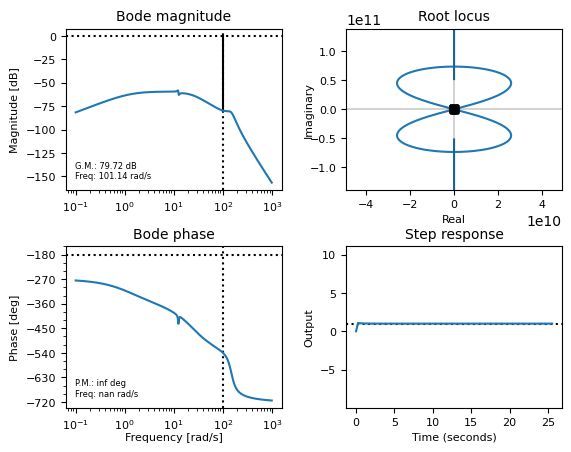

In [65]:
ct.rootlocus_pid_designer(Gaa2,gain='P', input_signal='r', Kp0=1, Ki0=1.2, Kd0=0,plot='bool')

In [66]:
# S_Gxr['RiseTime']    

In [67]:
#AFF: Retroacao da aceleração
damp(Gaa_a2)

    Eigenvalue (pole)       Damping     Frequency
    -25.94    +150.1j        0.1703         152.3
    -25.94    -150.1j        0.1703         152.3
               -40.65             1         40.65
   -0.4183    +12.51j       0.03341         12.52
   -0.4183    -12.51j       0.03341         12.52


(array([152.32469805, 152.32469805,  40.6504065 ,  12.52066731,
         12.52066731]),
 array([0.17030794, 0.17030794, 1.        , 0.0334075 , 0.0334075 ]),
 array([-25.94210558+150.09936973j, -25.94210558-150.09936973j,
        -40.6504065   +0.j        ,  -0.41828415 +12.51367845j,
         -0.41828415 -12.51367845j]))

In [68]:
zeros(Gaa_a2)

array([-0.25132726+12.56385711j, -0.25132726-12.56385711j,
        0.         +0.j        ])

5 states have been removed from the model


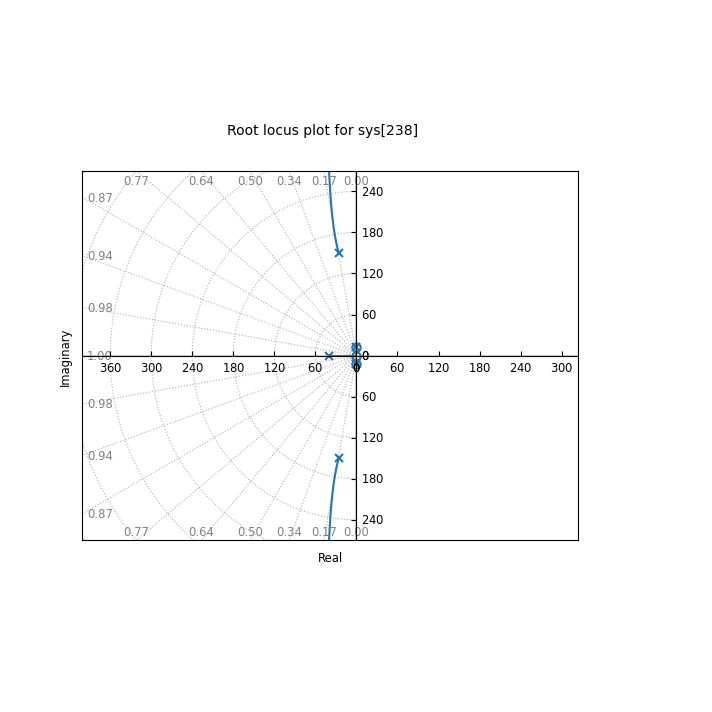

In [69]:
#AFF: Retroacao da aceleração
#Controlador Proporcional
#P:  C_f = ka
ka=1
Gaaf=Gaa_a2*ka/(1+Gaa_a2*ka)
Gaaf2=minreal(Gaaf)     #reducao do modelo

#ct.root_locus(Gaa_a2)
ct.root_locus(Gaa_a2)#, ylim=[5,50])

In [70]:
Gaaf2

TransferFunction(array([1.44520985e+07, 7.26441257e+06, 2.28218392e+09, 0.00000000e+00]), array([1.00000000e+00, 9.33711859e+01, 1.44776446e+07, 8.24329792e+06,
       2.28694105e+09, 1.47863335e+08]))

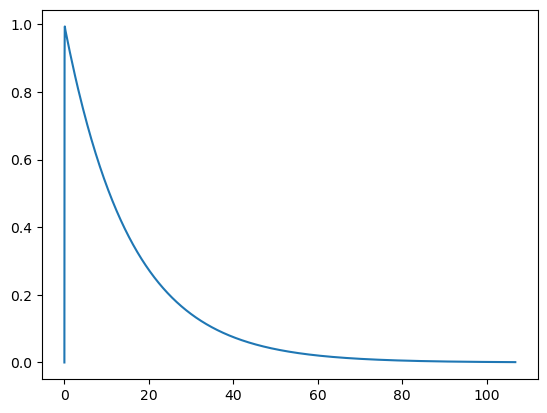

In [71]:
# Step response for the system
plt.figure(3)

#FT=Gaa2     #Gaa2=xp/isv
#FT=Gaa_a2  # Gaa2=ap/isv
FT=Gaaf2   #Gaaf2=ap/ap_ref

yout, T = step(FT)
plt.plot(T.T, yout.T)
plt.show(block=False)

c:\Users\afons\miniconda3\Lib\site-packages\control\bdalg.py:468: FutureWarning: connect() is deprecated; use interconnect()
  warn("connect() is deprecated; use interconnect()", FutureWarning)


StateSpace(array([[-9.33711859e+01, -1.70067091e+02,  1.05152947e+01,
        -2.75789714e+01, -1.47863335e+01,  0.00000000e+00,
         0.00000000e+00],
       [ 1.00000000e+03, -4.20160254e-14,  2.71687061e-16,
         4.25735313e-13, -6.61976900e-14,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.00000000e+02, -5.53944899e-15,
        -4.01547464e-15,  7.60430614e-15,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.00000000e+01,
         8.87310805e-14, -1.25458907e-14,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+01,  2.66453526e-15,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.44520985e+02, -7.26441257e-01,
         2.28218392e+01, -7.10542736e-15,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.44520985e+04,  7.26441257e+01,
        -2.28218392e+03,  7.10542736e-13,  0.00000000e+00,
       

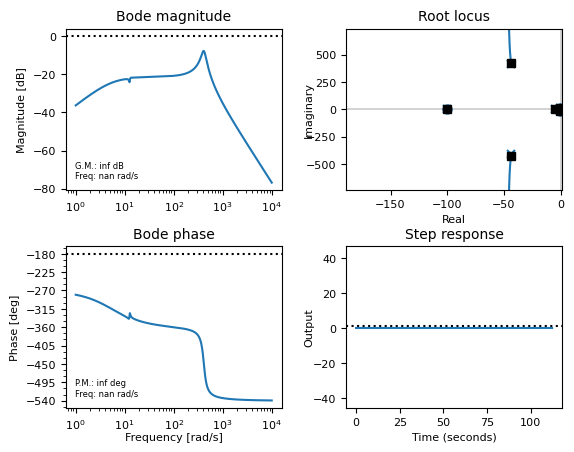

In [72]:
ct.rootlocus_pid_designer(Gaa_a2,gain='P', sign=1, input_signal='r', Kp0=0.01, Ki0=0, Kd0=0,)

In [73]:
from ipywidgets import interact

def f(x):
  print(x)
    
interact(f, x=10);

interactive(children=(IntSlider(value=10, description='x', max=30, min=-10), Output()), _dom_classes=('widget-…

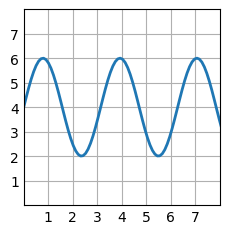

In [74]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data
x = np.linspace(0, 10, 100)
y = 4 + 2 * np.sin(2 * x)

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))

plt.show()